In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
data = pd.read_csv('data.csv').to_numpy()
data = (data - data.mean(axis=1).reshape(-1, 1)) / data.std(axis=1).reshape(-1, 1)

In [5]:
train_length = round(len(data) * 0.8)

train_data = torch.tensor(data[:train_length], dtype=torch.float32)
test_data = torch.tensor(data[train_length:], dtype=torch.float32)
all_data = torch.tensor(data, dtype=torch.float32)

In [6]:
train_loader = DataLoader(TensorDataset(train_data), batch_size=16, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data), batch_size=16, shuffle=False)
all_loader = DataLoader(TensorDataset(all_data), batch_size=16, shuffle=True)

In [7]:
class GRUEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, encoding_size, num_layers):
        super(GRUEncoder, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, num_layers=num_layers) # B x L x 2 * hid, 2 x B x hid
        self.enc = nn.Linear(hidden_size, encoding_size)

    def forward(self, x):
        x, h = self.gru(x)
        h = self.enc(h)
        return h

class GRUDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, encoding_size, num_layers):
        super(GRUDecoder, self).__init__()
        self.enc = nn.Linear(encoding_size, hidden_size)
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True) # B x L x hid, 1 x B x hid
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.out = nn.Linear(hidden_size, input_size)

    def forward(self, h, seq_len=31):
        x = torch.zeros((h.shape[1], seq_len, h.shape[2]), device=h.device, requires_grad=True)
        h = self.enc(h)
        x, _ = self.gru(x, h)
        x = self.layer_norm(x)
        x = self.out(x)
        return x

class GRUAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, encoding_size, num_layers=1):
        super(GRUAutoencoder, self).__init__()
        self.encoder = GRUEncoder(input_size, hidden_size, encoding_size, num_layers)
        self.decoder = GRUDecoder(input_size, hidden_size, encoding_size, num_layers)
    def forward(self, x):
        h = self.encoder(x)
        x = self.decoder(h)
        return x

In [8]:
model = GRUAutoencoder(input_size=48, hidden_size=256, encoding_size=48, num_layers=1).to(device)

In [9]:
k = 0
for param in model.parameters():
    if param.requires_grad:
        k += torch.prod(torch.tensor(param.size()))
print(f'Model has {k} trainable parameters')

Model has 507744 trainable parameters


In [10]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [11]:
all_train_losses = []
train_losses = []
test_losses = []

In [12]:
epochs = 200

for epoch in range(epochs):
    avg_loss = 0
    model.train()
    for batch in train_loader:
        batch = batch[0].view(-1, 31, 48).to(device)
        preds = model(batch)
        loss = criterion(preds, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        all_train_losses.append(loss.item())
        avg_loss += loss.item()
    avg_loss /= len(train_loader)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')
    train_losses.append(avg_loss)
    
    model.eval()
    avg_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch[0].view(-1, 31, 48).to(device)
            preds = model(batch)
            loss = criterion(preds, batch)
            
            avg_test_loss += loss.item()
    avg_test_loss /= len(test_loader)
    test_losses.append(avg_test_loss)

    print(f'Test Loss: {avg_test_loss:.4f}')

Epoch 1, Loss: 0.7265
Test Loss: 0.6009
Epoch 2, Loss: 0.5879
Test Loss: 0.5856
Epoch 3, Loss: 0.5632
Test Loss: 0.5282
Epoch 4, Loss: 0.5112
Test Loss: 0.4993
Epoch 5, Loss: 0.4919
Test Loss: 0.4858
Epoch 6, Loss: 0.4823
Test Loss: 0.4753
Epoch 7, Loss: 0.4729
Test Loss: 0.4697
Epoch 8, Loss: 0.4684
Test Loss: 0.4644
Epoch 9, Loss: 0.4649
Test Loss: 0.4595
Epoch 10, Loss: 0.4592
Test Loss: 0.4554
Epoch 11, Loss: 0.4525
Test Loss: 0.4521
Epoch 12, Loss: 0.4508
Test Loss: 0.4491
Epoch 13, Loss: 0.4476
Test Loss: 0.4461
Epoch 14, Loss: 0.4444
Test Loss: 0.4410
Epoch 15, Loss: 0.4415
Test Loss: 0.4365
Epoch 16, Loss: 0.4364
Test Loss: 0.4317
Epoch 17, Loss: 0.4294
Test Loss: 0.4265
Epoch 18, Loss: 0.4267
Test Loss: 0.4233
Epoch 19, Loss: 0.4255
Test Loss: 0.4210
Epoch 20, Loss: 0.4204
Test Loss: 0.4187
Epoch 21, Loss: 0.4209
Test Loss: 0.4166
Epoch 22, Loss: 0.4174
Test Loss: 0.4149
Epoch 23, Loss: 0.4164
Test Loss: 0.4138
Epoch 24, Loss: 0.4161
Test Loss: 0.4125
Epoch 25, Loss: 0.4169
Te

In [13]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f'{name} grad: {param.grad.abs().mean()}')

encoder.gru.weight_ih_l0 grad: 0.00029972565243951976
encoder.gru.weight_hh_l0 grad: 9.805699664866552e-05
encoder.gru.bias_ih_l0 grad: 0.0004175861831754446
encoder.gru.bias_hh_l0 grad: 0.0003150685806758702
encoder.enc.weight grad: 0.0005780009087175131
encoder.enc.bias grad: 0.0013702074065804482
decoder.enc.weight grad: 0.0006127042579464614
decoder.enc.bias grad: 0.0007299644639715552
decoder.gru.weight_ih_l0 grad: 0.0
decoder.gru.weight_hh_l0 grad: 0.00023333795252256095
decoder.gru.bias_ih_l0 grad: 0.0007456173188984394
decoder.gru.bias_hh_l0 grad: 0.0006067465874366462
decoder.layer_norm.weight grad: 0.0006507819052785635
decoder.layer_norm.bias grad: 0.0004302923916839063
decoder.out.weight grad: 0.0021806349977850914
decoder.out.bias grad: 0.0016614689957350492


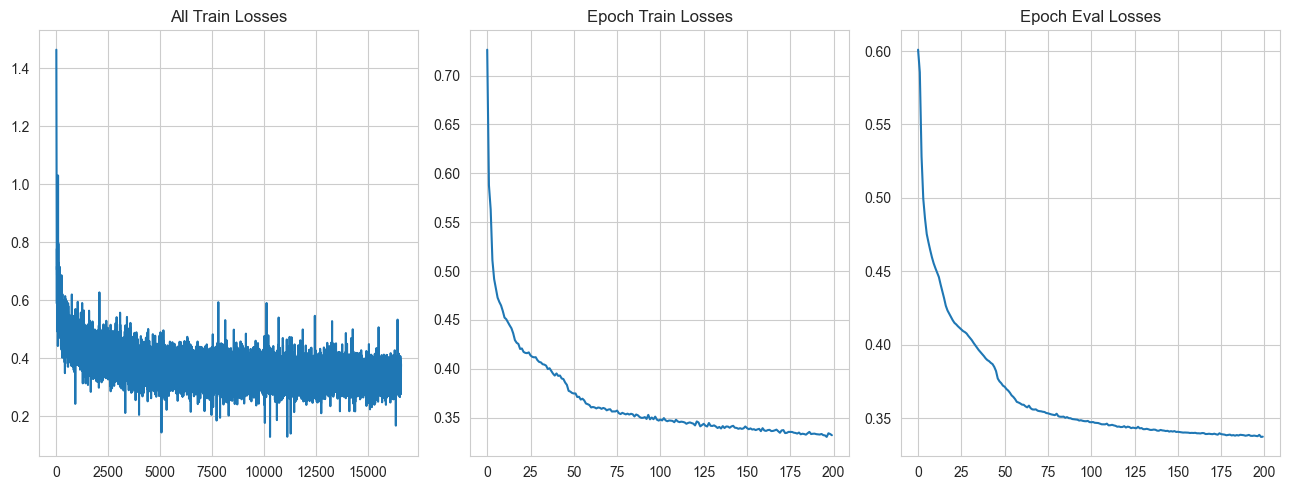

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))
axes[0].plot(all_train_losses)
axes[0].set_title('All Train Losses')
axes[1].plot(train_losses)
axes[1].set_title('Epoch Train Losses')
axes[2].plot(test_losses)
axes[2].set_title('Epoch Eval Losses')
plt.tight_layout()
plt.show()

In [15]:
model = GRUAutoencoder(input_size=48, hidden_size=256, encoding_size=48, num_layers=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [16]:
epochs = 150

for epoch in range(epochs):
    avg_loss = 0
    model.train()
    for batch in all_loader:
        batch = batch[0].view(-1, 31, 48).to(device)
        preds = model(batch)
        loss = criterion(preds, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
    avg_loss /= len(train_loader)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')

Epoch 1, Loss: 0.8518
Epoch 2, Loss: 0.7191
Epoch 3, Loss: 0.6470
Epoch 4, Loss: 0.6129
Epoch 5, Loss: 0.5952
Epoch 6, Loss: 0.5813
Epoch 7, Loss: 0.5714
Epoch 8, Loss: 0.5658
Epoch 9, Loss: 0.5613
Epoch 10, Loss: 0.5580
Epoch 11, Loss: 0.5541
Epoch 12, Loss: 0.5478
Epoch 13, Loss: 0.5403
Epoch 14, Loss: 0.5342
Epoch 15, Loss: 0.5301
Epoch 16, Loss: 0.5262
Epoch 17, Loss: 0.5223
Epoch 18, Loss: 0.5192
Epoch 19, Loss: 0.5166
Epoch 20, Loss: 0.5139
Epoch 21, Loss: 0.5115
Epoch 22, Loss: 0.5092
Epoch 23, Loss: 0.5068
Epoch 24, Loss: 0.5049
Epoch 25, Loss: 0.5027
Epoch 26, Loss: 0.5013
Epoch 27, Loss: 0.4991
Epoch 28, Loss: 0.4980
Epoch 29, Loss: 0.4960
Epoch 30, Loss: 0.4933
Epoch 31, Loss: 0.4900
Epoch 32, Loss: 0.4824
Epoch 33, Loss: 0.4755
Epoch 34, Loss: 0.4730
Epoch 35, Loss: 0.4711
Epoch 36, Loss: 0.4683
Epoch 37, Loss: 0.4658
Epoch 38, Loss: 0.4640
Epoch 39, Loss: 0.4613
Epoch 40, Loss: 0.4584
Epoch 41, Loss: 0.4565
Epoch 42, Loss: 0.4546
Epoch 43, Loss: 0.4533
Epoch 44, Loss: 0.45

In [17]:
errors = []
encoded = []
reconstructed = []
with torch.no_grad():
    for sample in all_data:
        inputs = sample.view(-1, 31, 48).to(device)
        res = model(inputs).cpu().detach().flatten()
        reconstruction_error = criterion(res, sample)
        errors.append(reconstruction_error.cpu().detach().numpy())
        
        features = model.encoder(inputs).view(-1)
        encoded.append(features.cpu().detach().numpy())
        
        reconstructed.append(res.view(-1).cpu().detach().numpy())
errors = np.array(errors)
encoded = np.array(encoded)
reconstructed = np.array(reconstructed)

In [18]:
def plot_sample(sample):
    _, ax = plt.subplots(figsize=(20, 5))
    ax.plot(data[sample], label='True Row')
    pred_row = reconstructed[sample]
    ax.plot(pred_row, label='Predicted Row')
    mse = np.linalg.norm(data[sample] - pred_row) ** 2 / len(data[sample])
    ax.set_title(f'Model Prediction VS True Row, MSE: {mse.round(2)}, Sample: {sample}')
    plt.legend()
    plt.show()

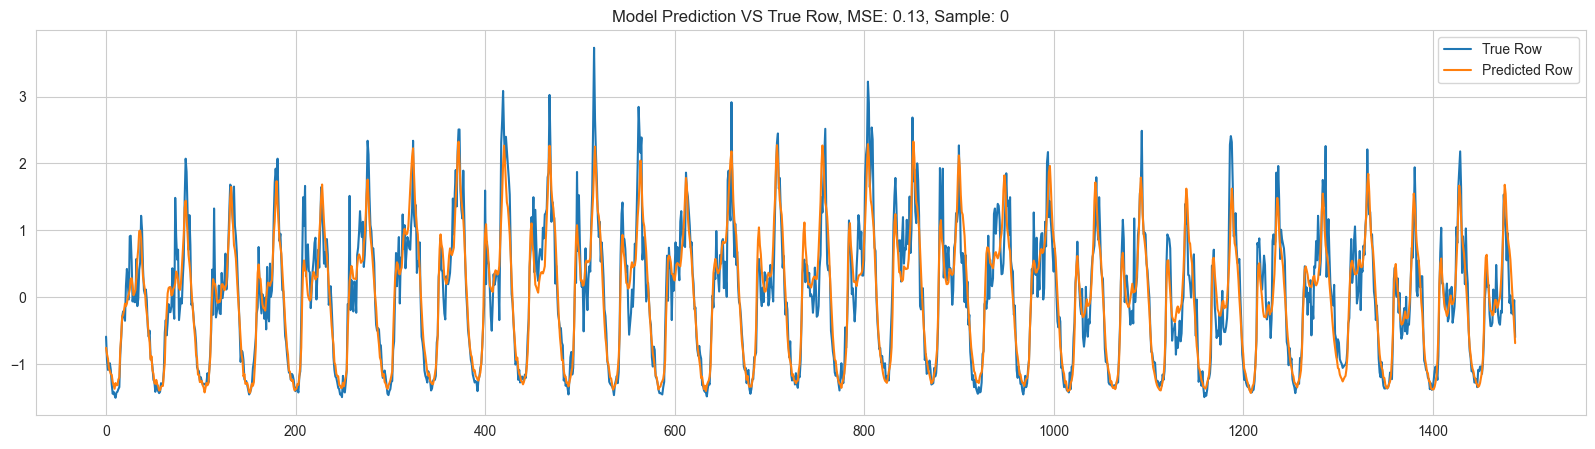

In [19]:
plot_sample(0)

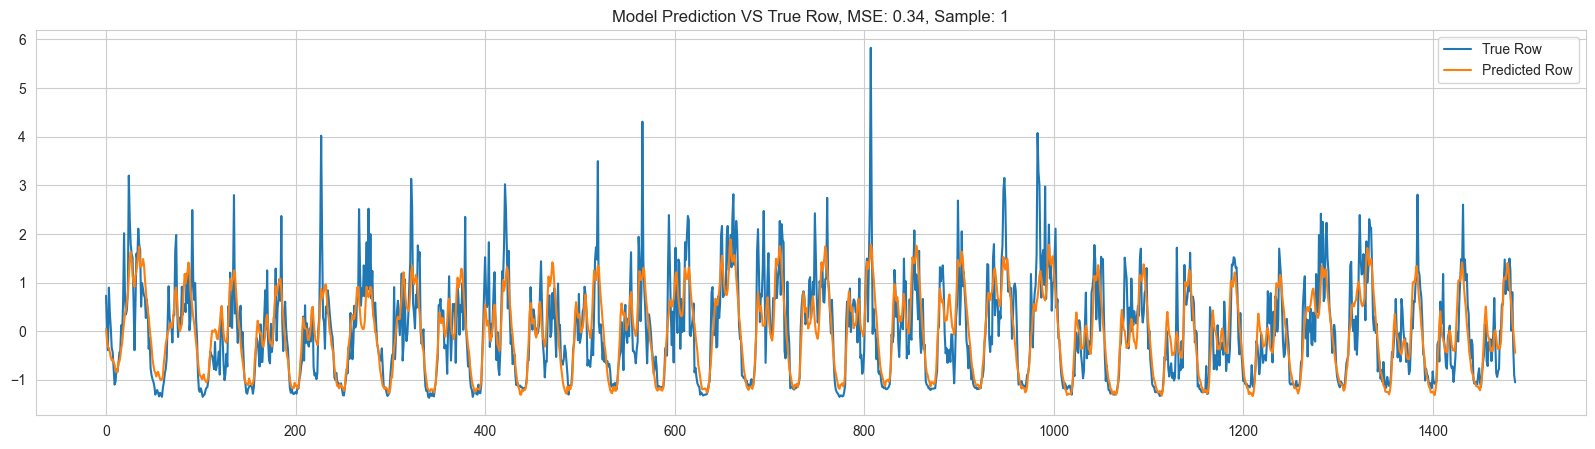

In [20]:
plot_sample(1)

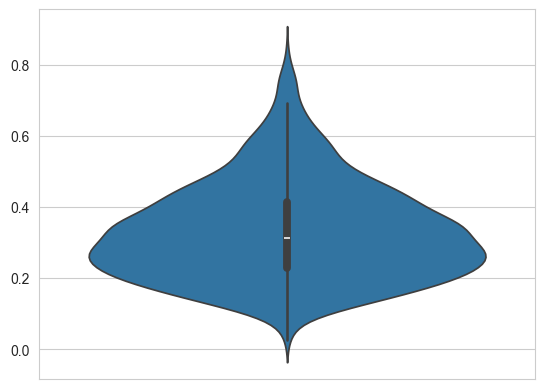

In [21]:
sns.violinplot(errors)
plt.show()

In [22]:
np.quantile(errors, 0.99)

0.7335494047403324

In [23]:
np.column_stack((np.argsort(-errors), -np.sort(-errors)))

array([[1.57800000e+03, 8.46446216e-01],
       [3.94000000e+02, 8.08910847e-01],
       [1.16800000e+03, 8.00710022e-01],
       ...,
       [1.10200000e+03, 4.32425365e-02],
       [6.54000000e+02, 3.02003473e-02],
       [2.23000000e+02, 2.72977408e-02]])

In [24]:
# 1578.0,0.847006
# 394.0,0.807957
# 1168.0,0.804210
# 412.0,0.791402
# 142.0,0.790078
# 950.0,0.783746
# 122.0,0.779672
# 1034.0,0.776447
# 170.0,0.766672
# 488.0,0.761063


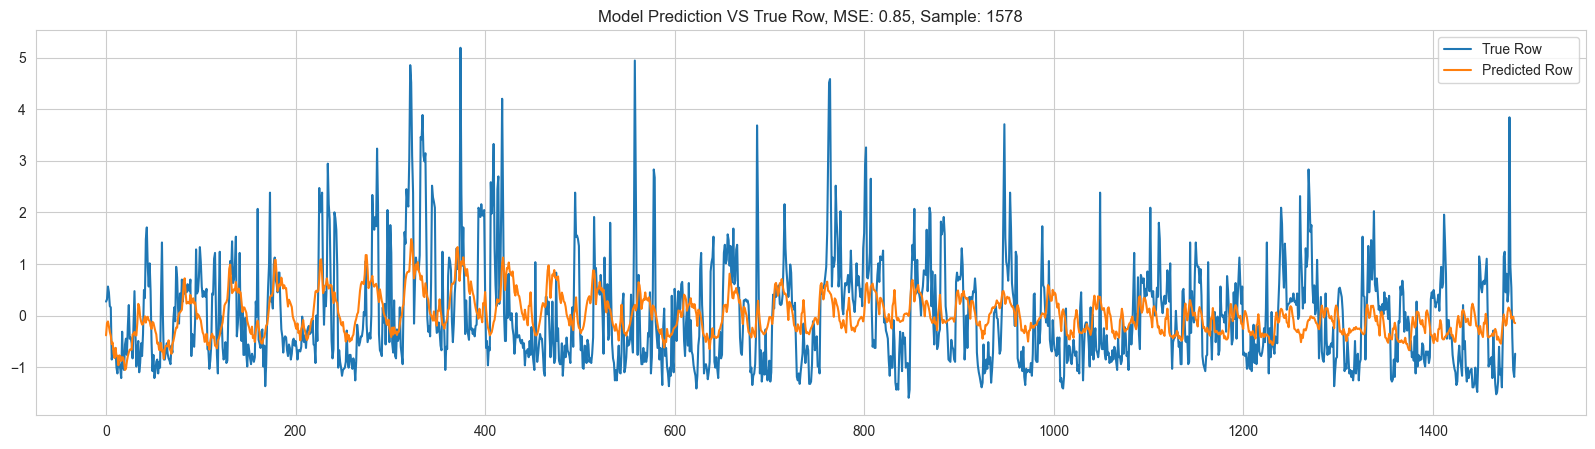

In [25]:
plot_sample(1578)

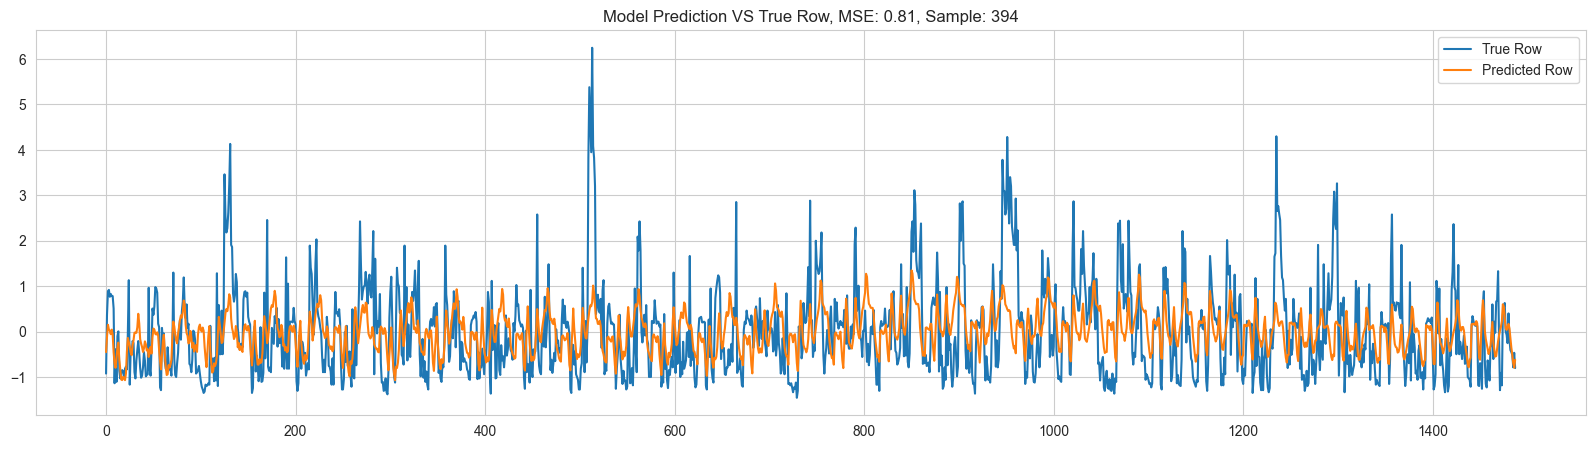

In [26]:
plot_sample(394)

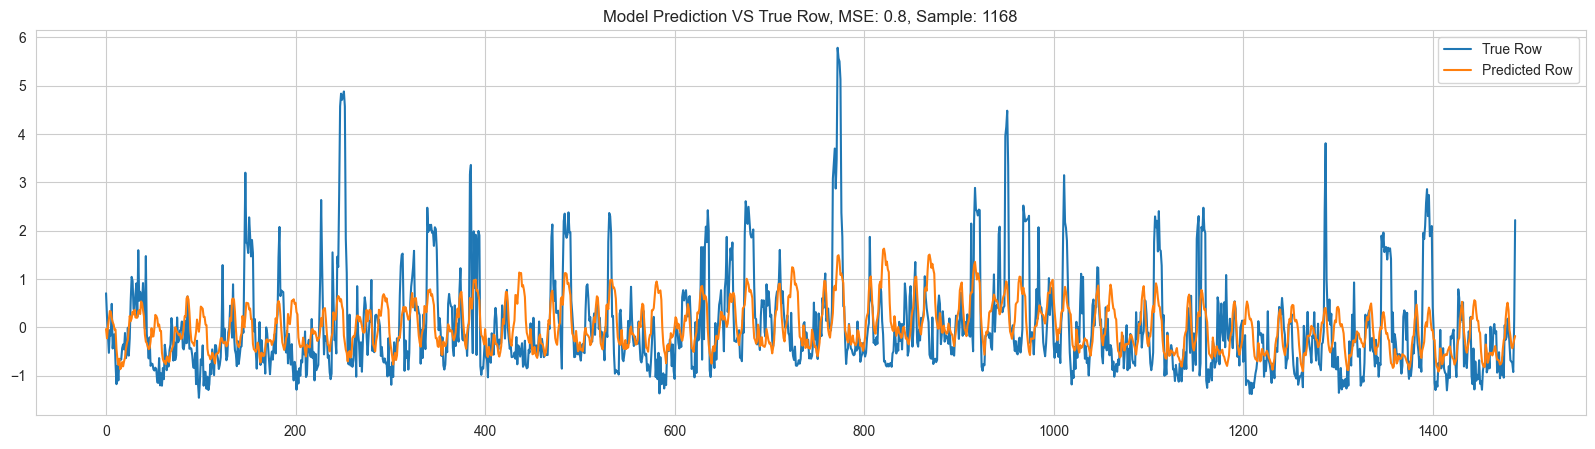

In [27]:
plot_sample(1168)

In [30]:
# torch.save(model.state_dict(), './models/rec_autoenc_subsec.pt')

In [31]:
encoded_norm = (encoded - encoded.mean(axis=0)) / encoded.std(axis=0)

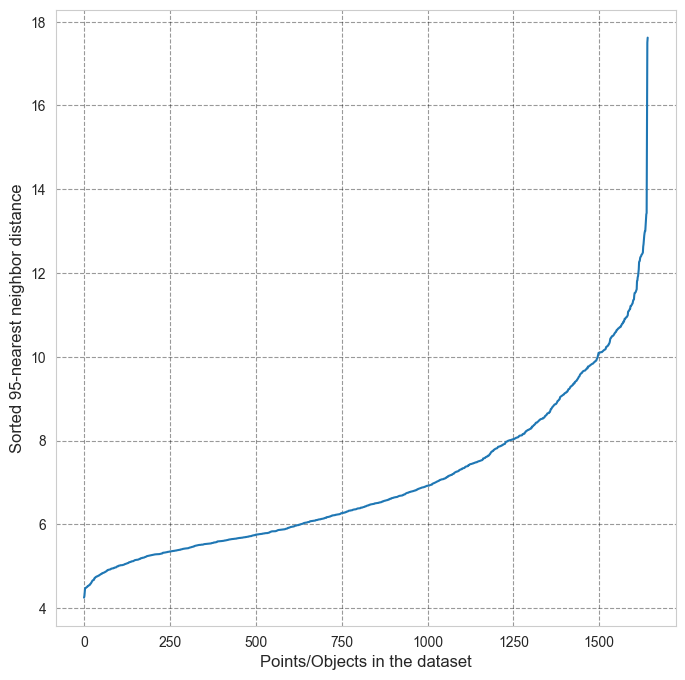

In [32]:
from sklearn.neighbors import NearestNeighbors


def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()


k = 2 * encoded_norm.shape[-1] - 1 # k=2*{dim(dataset)} - 1
get_kdist_plot(X=encoded_norm, k=k)

In [33]:
from sklearn.cluster import DBSCAN

# Создаем объект DBSCAN
dbscan = DBSCAN(eps=9.64, min_samples=25)

# Проводим кластеризацию данных
clusters = dbscan.fit_predict(encoded_norm)

# Ищем объекты, отнесенные к кластеру -1 (это аномалии)
anomalies_indices = np.where(clusters == -1)[0]
anomalies_indices

# 1168, 1178, 1633

array([  28,  272,  528,  677,  921,  936, 1014, 1018, 1162, 1189, 1486],
      dtype=int64)

In [34]:
anomalies_indices.reshape(-1, 1)

array([[  28],
       [ 272],
       [ 528],
       [ 677],
       [ 921],
       [ 936],
       [1014],
       [1018],
       [1162],
       [1189],
       [1486]], dtype=int64)

In [35]:
# 28,  462,  528,  677,  921,  936, 1014, 1018, 1189, 1486

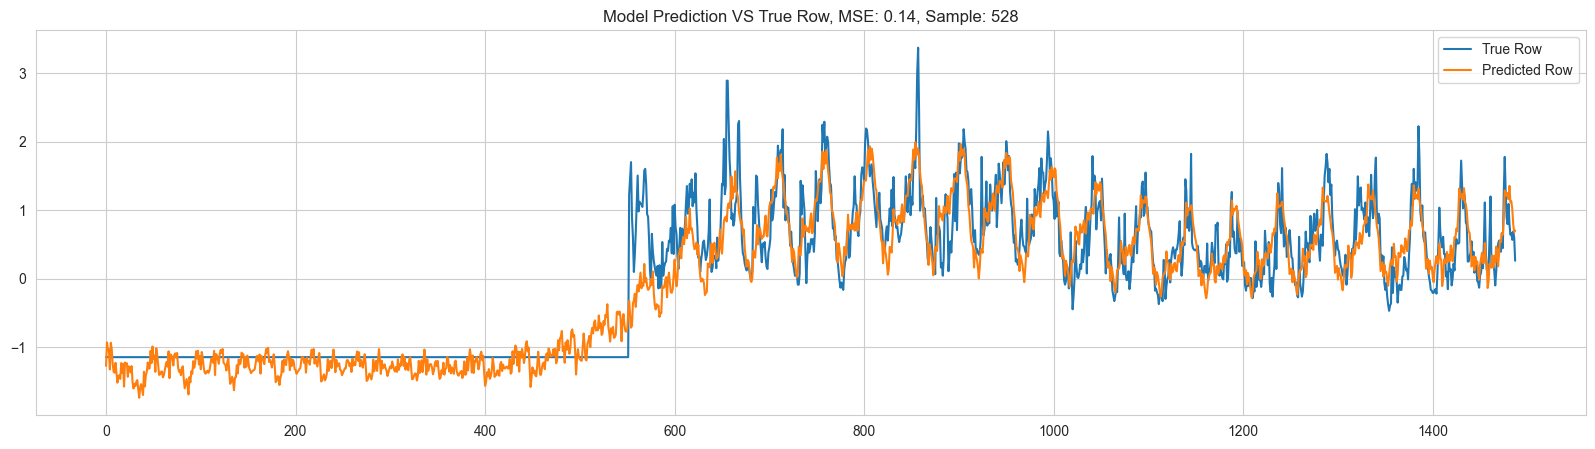

In [36]:
plot_sample(528)

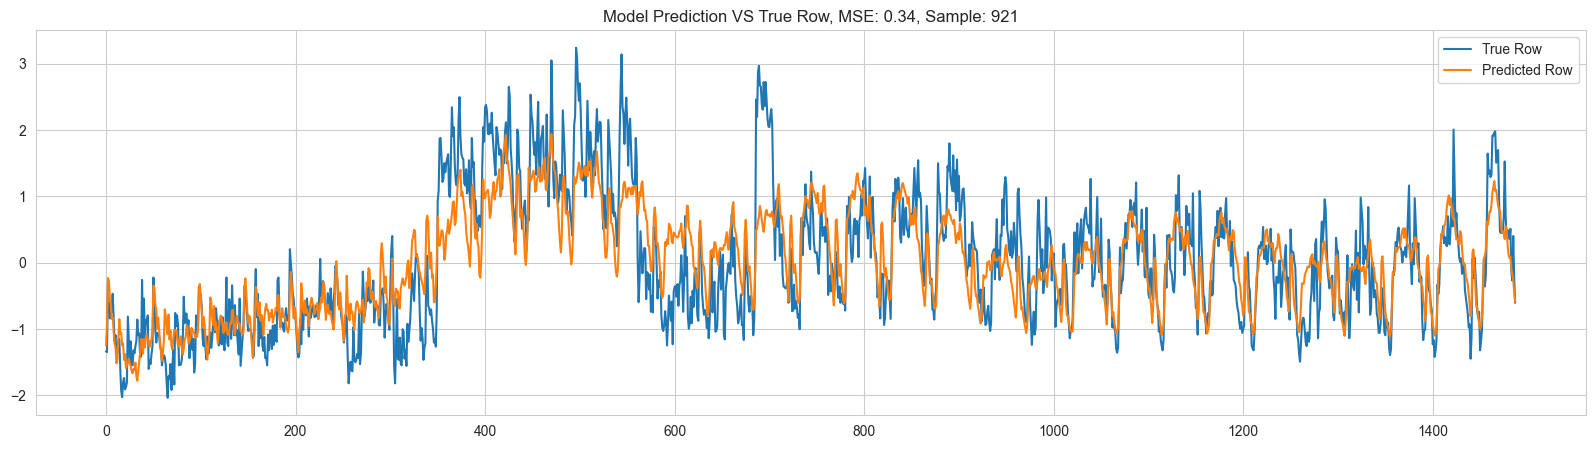

In [37]:
plot_sample(921)

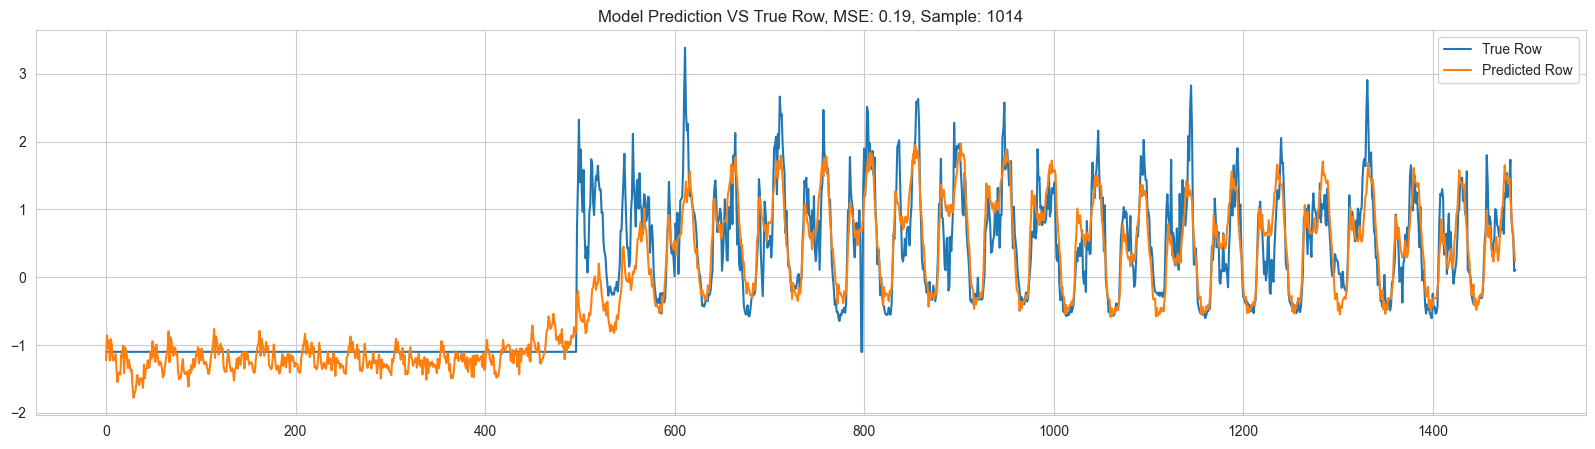

In [38]:
plot_sample(1014)

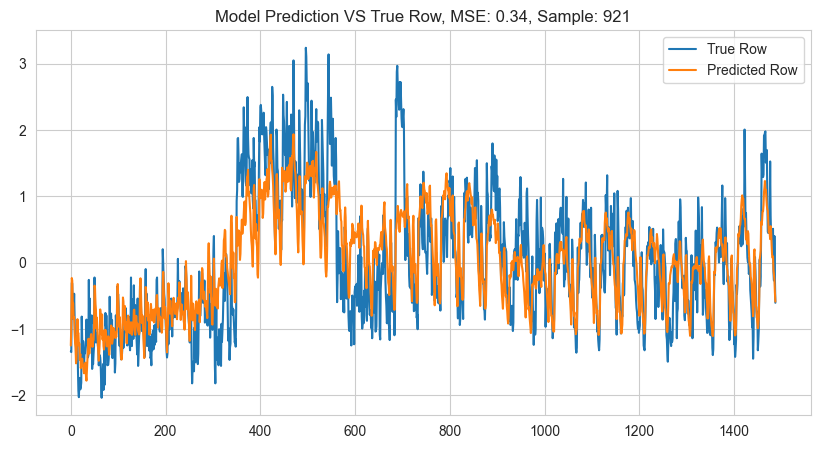

In [60]:
def plot_sample(sample):
    _, ax = plt.subplots(figsize=(10, 5))
    ax.plot(data[sample], label='True Row')
    pred_row = reconstructed[sample]
    ax.plot(pred_row, label='Predicted Row')
    mse = np.linalg.norm(data[sample] - pred_row) ** 2 / len(data[sample])
    ax.set_title(f'Model Prediction VS True Row, MSE: {mse.round(2)}, Sample: {sample}')
    plt.legend()
    plt.show()
plot_sample(921)